## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import re
import json 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from IPython.display import clear_output

In [2]:
nltk.download('wordnet','/root/nltk_data/')

# Wordnet download is not automatically unzipping the downloaded package.
# Code to do that manually
import zipfile
with zipfile.ZipFile('/root/nltk_data/corpora/wordnet.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/nltk_data/corpora/')
print("Downloaded package successfully unzipped")

[nltk_data] Downloading package wordnet to /root/nltk_data/...
Downloaded package successfully unzipped


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
with open('/kaggle/input/upgrad-nlp-automatic-ticket-classification/complaints-2021-05-14_08_16.json') as f:
    
    # returns JSON object as  
    # a dictionary 
    data = json.load(f)
    df=pd.json_normalize(data)

## Data preparation

In [4]:
df.shape

(78313, 22)

Checking for columns without single values

In [5]:
df.nunique()

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.tags                             3
_source.zip_code                      9442
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          3
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      205
_source.consumer_consent_provided        5
dtype: int64

Removing columns that have 1 unique ID (ie, the entire column only have one value) and ID columns

In [6]:
df.drop(columns=['_index','_type','_id','_score','_source.complaint_id'],inplace=True)
df.nunique()

_source.tags                             3
_source.zip_code                      9442
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          3
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      205
_source.consumer_consent_provided        5
dtype: int64

In [7]:
df.shape

(78313, 17)

In [8]:
# Inspect the dataframe to understand the given data.
df.head()

,_source.tags,_source.zip_code,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#print the column names
df.columns

Index(['_source.tags', '_source.zip_code', '_source.issue',
       '_source.date_received', '_source.state', '_source.consumer_disputed',
       '_source.product', '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product',
       '_source.timely', '_source.complaint_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names
df.columns = ['tags','zip_code','issue','date_received','state','consumer_disputed','product',
              'company_response','company','submitted_via','date_sent_to_company','company_public_response','sub_product',
             'timely','complaint_what_happened','sub_issue','consumer_consent_provided']
df.head()

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df.loc[ df['complaint_what_happened'] == '' ] = np.nan

In [12]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,None,104XX,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,None,750XX,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,None,920XX,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [13]:
df.shape

(21072, 17)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements, and tokenize.
def clean_n_tokenize(str_data):
    str_data = str_data.lower()
    str_data = re.sub(r'\[.*\]','',str_data)
    str_data = re.sub(r'[^\w\s]','',str_data)
    str_data = re.sub(r'\b\w*\d\w*\b','',str_data)
    str_data = re.sub(r'\n{2,}','\n',str_data)
    str_data = re.sub(r'\s{2,}',' ',str_data)
    return str_data

In [15]:
# Write POS tagging function
def pos_tag_str(str_data):
    doc = nlp(str_data)
    token_list = []
    pos_list = []
    for token in doc:
        token_list += [token.text]
        pos_list += [token.tag_]
    return token_list,pos_list

In [16]:
#Write your function to Lemmatize the texts
def lemmatize_token_list(token_list, pos_list):
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    
    def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif pos_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif pos_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif pos_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN
    
    lemmatized_token_list = [ wordnet_lemmatizer.lemmatize(token,pos=get_wordnet_pos(pos)) for token,pos in zip(token_list,pos_list) ]
    return lemmatized_token_list

In [17]:
#Create a dataframe('df_clean') that will have only the complaints, the lemmatized complaints and the complaint after removing POS tags.

df_clean = pd.DataFrame(columns=['raw_complaint', 'lemmatized_complaint_token_list', 'cleaned_complaint_token_list'])
total_rows = df.shape[0]

for idx,row in df.iterrows():
    raw_complaint = row['complaint_what_happened']
    processed_complaint = clean_n_tokenize(raw_complaint)
    complaint_token_list, complaint_pos_list = pos_tag_str(processed_complaint)
    lemmatized_complaint_token_list = lemmatize_token_list(complaint_token_list, complaint_pos_list)
    cleaned_complaint_token_list = [ lemmatized_token \
                                    for lemmatized_token,pos in zip(lemmatized_complaint_token_list,complaint_pos_list) \
                                   if pos=='NN']
    
    df_clean.loc[idx,'raw_complaint'] = raw_complaint
    df_clean.loc[idx,'lemmatized_complaint_token_list'] = lemmatized_complaint_token_list
    df_clean.loc[idx,'cleaned_complaint_token_list'] = cleaned_complaint_token_list
    
    clear_output(wait=True)
    print(f'Completed {idx+1} rows out of {total_rows}')

Completed 21072 rows out of 21072


In [18]:
df_clean.head()

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[xxxx, agent, anniversary, date, agent, inform..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[xxxx, ticket, offer, ticket, card, informatio..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



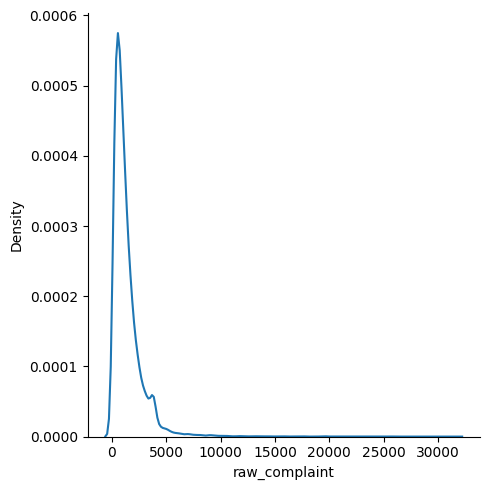

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



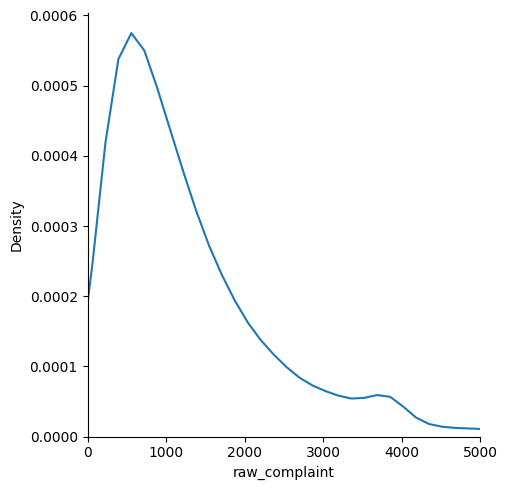

In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_length = df_clean['raw_complaint'].str.len()
char_length.rename('Raw-Complaint-Character-Length')
sns.displot(x=char_length, kind='kde')
plt.show()
sns.displot(x=char_length, kind='kde')
plt.xlim(0,5000)
plt.show()

There seems to be complaints with more than 30000 characters, but the majority complaints have character length lingering somewhere around 1000

#### Find the top 40 words by frequency among all the articles after processing the text.

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
top_40_words = df_clean.explode('lemmatized_complaint_token_list')['lemmatized_complaint_token_list'].value_counts()[:40]
top_40_words.name = 'Frequency'
top_40_words

lemmatized_complaint_token_list
the         238878
be          211862
i           198780
xxxx        192206
to          181842
and         145382
a           129206
my          106554
have         87671
that         86730
chase        80326
of           79190
on           62941
in           62225
they         56413
for          55348
me           51797
not          51544
account      48639
this         47422
with         43880
it           41890
do           40833
credit       34133
card         30496
from         30321
bank         28383
xxxxxxxx     27900
call         26031
payment      21130
would        20741
at           20365
tell         19651
by           18961
we           18491
charge       18217
an           18185
receive      17734
no           17610
or           17473
Name: Frequency, dtype: int64

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_30_unigrams():
    top_30_unigram_freq = df_clean.explode('lemmatized_complaint_token_list')['lemmatized_complaint_token_list'].value_counts()[:30]
    top_30_unigrams = top_30_unigram_freq.index.to_list()
    return top_30_unigrams

In [26]:
#Print the top 10 words in the unigram frequency
top_30_unigrams = get_top_30_unigrams()
top_10_unigrams = top_30_unigrams[:10]
top_10_unigrams

['the', 'be', 'i', 'xxxx', 'to', 'and', 'a', 'my', 'have', 'that']

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

all_complaints_concat = df_clean['raw_complaint'].str.cat(sep=' ')
all_complaints_tokenized_sentences = nltk.tokenize.sent_tokenize(all_complaints_concat)

def get_all_possible_bigrams():
    all_bigrams = []
    total_sentences = len(all_complaints_tokenized_sentences)
    for idx,sentence in enumerate(all_complaints_tokenized_sentences):
        all_words_in_sent = nltk.tokenize.word_tokenize(sentence)
        for first_word, last_word in zip(all_words_in_sent[:-1], all_words_in_sent[1:]):
            bigram = first_word + ' ' + last_word
            bigram = bigram.lower()
            if bigram not in all_bigrams:
                all_bigrams += [bigram]
        
        clear_output(wait=True)
        print(f'Completed {idx+1} sentences out of {total_sentences}')
        
    return all_bigrams

def get_substring_probability(substring):
    pass

def get_top_30_bigrams():
    
    all_possible_bigrams = get_all_possible_bigrams()
    prob_of_possible_bigrams = [ get_substring_probability(bigram) for bigram in all_possible_bigrams ]

get_all_possible_bigrams()[:10]

Completed 24907 sentences out of 249876
Completed 24907 sentences out of 249876


In [ ]:
#Print the top 10 words in the bigram frequency

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



